In [1]:
#import gdb

In [2]:
import pandas as pd
import numpy as np
from torchvision import *

In [3]:
trn = pd.read_csv('../train.csv',index_col='ID_code')
tst = pd.read_csv('../test.csv',index_col='ID_code')

In [4]:
trn.reset_index(inplace=True)
trn.drop('ID_code',inplace=True,axis=1)
trn.head(2)

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.093,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.389,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518


In [5]:
trn_1 = trn.loc[trn.target==1,:]
trn_0 = trn.loc[trn.target==0,:][:len(trn_1)]
len(trn_1),len(trn_0)

(20098, 20098)

In [6]:
val_index = np.append(trn_1.index.values,trn_0.index.values)
val_index = np.setdiff1d(trn.index.values,val_index)

In [7]:
len(val_index),len(trn)-2*(len(trn_0))

(159804, 159804)

In [8]:
val_index = np.append(val_index,trn_1.index.values[:int(0.2*len(trn_1))])

In [9]:
from fastai.tabular import *
from fastai.metrics import *
import torchvision.models as models

In [10]:
def basic_blk(n_in,n_out):
    return  nn.Sequential(nn.Conv1d(n_in,n_out,3),
                               nn.BatchNorm1d(n_out),
                               nn.ReLU(inplace=True),
                               nn.Conv1d(n_out,n_out,3),
                               nn.BatchNorm1d(n_out))
def begin_blk(n_in,n_out):
    return nn.Sequential(nn.Conv1d(n_in,n_out,3),
                        nn.BatchNorm1d(n_out),
                        nn.ReLU(inplace=True),
                        nn.MaxPool1d(3,stride=2))
def head(n_in,n_out):
    return nn.Sequential(nn.AdaptiveAvgPool1d(1),
                        #nn.AdaptiveMaxPool1d(1),
                        Flatten(),
                        nn.BatchNorm1d(n_in),
                        nn.Dropout(0.2),
                        nn.Linear(n_in,n_out),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm1d(n_out),
                        nn.Dropout(0.2),
                        nn.Linear(n_out,2))

In [11]:
class conv_struct(nn.Module):
    def __init__(self,lyrs):
        super().__init__()
        self.bk = begin_blk(1,lyrs[0])
        self.body_lyrs = [basic_blk(lyrs[i],lyrs[i+1]) for i in range(0,len(lyrs)-2)]
        self.body = nn.Sequential(*self.body_lyrs)
        self.head = head(lyrs[-2],lyrs[-1])
        self.net = nn.Sequential(self.bk,
                                self.body,
                                self.head)
    def forward(self,A,B):
        return self.net(B.view(-1,20,10))

In [12]:
data = (TabularList.from_df(trn,cont_names=tst.columns,procs=[Normalize])
       .split_by_idx(val_index)
       .label_from_df(cols='target')
        .add_test(TabularList.from_df(tst))
       .databunch(num_workers=16))

In [29]:
_ = models.resnet34(True)

In [35]:
_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [13]:
class resnet_mod(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = models.resnet18(pretrained=True)
        #self.net.conv1 = nn.Conv2d(1,64,kernel_size=(3,3),stride=(2,2),padding=(3,3),bias=False)
        self.net.fc = nn.Sequential(nn.Linear(512,256),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm1d(256),
                           nn.Linear(256,128),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm1d(128),
                           nn.Linear(128,64),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm1d(64),
                           nn.Linear(64,8),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm1d(8),
                           nn.Linear(8,2))
        self.mean = [0.485, 0.456, 0.406]
        self.std  = [0.229, 0.224, 0.225]
    def forward(self,A,B):
        #gdb.set_trace()
        with torch.no_grad():
            self.d = B.view(-1,20,10)
            self.e = torch.stack(((self.d-self.mean[0])/self.std[0],
                                  (self.d-self.mean[1])/self.std[1],
                                  (self.d-self.mean[2])/self.std[1]),dim=1)
        return self.net(self.e)

In [14]:
learn = Learner(data,resnet_mod(),metrics=[accuracy,Precision(),Recall(),FBeta(beta=1)])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ravi/.torch/models/resnet34-333f7ec4.pth
87306240it [00:24, 3525460.39it/s]


In [15]:
learn.model

resnet_mod(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [28]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [17]:
trn_l = []
val_l = []
met = []

In [18]:
def collect_vals():
    trn_l.extend(learn.recorder.losses)
    val_l.extend(learn.recorder.val_losses)
    met.extend(learn.recorder.metrics)

In [26]:
requires_grad(learn.model.net.fc)

False

In [25]:
requires_grad(learn.model.net.layer4[0].conv1)

False

In [201]:
def freeze_mod(x=False):
    requires_grad(learn.model.net.conv1,x)
    
    requires_grad(learn.model.net.layer1[0].conv1,x)
    requires_grad(learn.model.net.layer1[0].conv2,x)
    requires_grad(learn.model.net.layer1[1].conv1,x)
    requires_grad(learn.model.net.layer1[1].conv2,x)

    requires_grad(learn.model.net.layer2[0].conv1,x)
    requires_grad(learn.model.net.layer2[0].conv2,x)
    requires_grad(learn.model.net.layer2[0].downsample[0],x)
    requires_grad(learn.model.net.layer2[1].conv1,x)
    requires_grad(learn.model.net.layer2[1].conv2,x)

    requires_grad(learn.model.net.layer3[0].conv1,x)
    requires_grad(learn.model.net.layer3[0].conv2,x)
    requires_grad(learn.model.net.layer3[0].downsample[0],x)
    requires_grad(learn.model.net.layer3[1].conv1,x)
    requires_grad(learn.model.net.layer3[1].conv2,x)

    requires_grad(learn.model.net.layer4[0].conv1,x)
    requires_grad(learn.model.net.layer4[0].conv2,x)
    requires_grad(learn.model.net.layer4[0].downsample[0],x)
    requires_grad(learn.model.net.layer4[1].conv1,x)
    requires_grad(learn.model.net.layer4[1].conv2,x)

In [202]:
#learn.model.net

In [261]:
freeze_mod(True)

In [315]:
data1 = (TabularList.from_df(trn,cont_names=tst.columns,procs=[Normalize])
       .split_by_rand_pct(0.2,seed=42)
       .label_from_df(cols='target')
        .add_test(TabularList.from_df(tst))
       .databunch(num_workers=16))

In [316]:
learn.data = data1

In [339]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


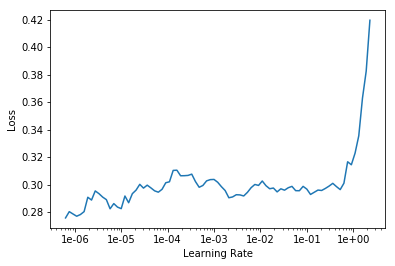

In [340]:
learn.recorder.plot()

In [341]:
learn.fit_one_cycle(10,max_lr=0.15)
collect_vals()
#learn.fit_one_cycle(10,max_lr=0.03)
#collect_vals()
#learn.fit_one_cycle(20,max_lr=0.06)
#collect_vals()

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.309570,0.302990,0.897700,0.526316,0.012204,0.023855,00:59
1,0.310656,0.316922,0.893150,0.377931,0.066878,0.113646,01:00
2,0.342163,0.340874,0.897550,0.000000,0.000000,0.000000,01:01
3,0.334626,2.851115,0.689200,0.101387,0.258726,0.145684,01:00
4,0.317758,0.354283,0.897575,nan,0.000000,0.000000,01:01
5,0.319217,0.340365,0.897575,nan,0.000000,0.000000,01:02
6,0.322541,0.330452,0.897575,nan,0.000000,0.000000,01:02
7,0.318575,0.328144,0.897575,nan,0.000000,0.000000,01:02
8,0.312607,0.327907,0.897575,0.500000,0.000732,0.001462,01:03
9,0.332569,0.326186,0.897575,nan,0.000000,0.000000,01:04


In [342]:
met_ = np.array(met)

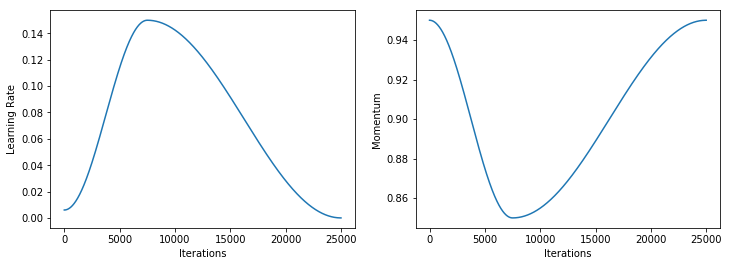

In [343]:
learn.recorder.plot_lr(show_moms=True)

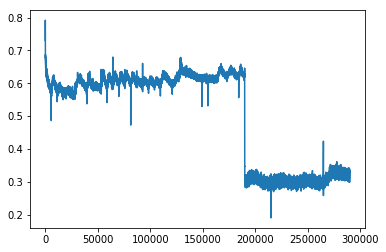

In [344]:
plt.plot(trn_l)

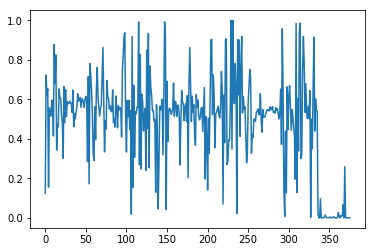

In [345]:
plt.plot(met_[:,2])

In [324]:
learn.save('fail')

In [269]:
learn.load('fail')

/home/ravi/miniconda3/envs/fastpy3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type resnet_mod. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=TabularDataBunch;

Train: LabelList (160000 items)
x: TabularList
var_0 -0.5784; var_1 -1.2743; var_2 0.4513; var_3 -0.8328; var_4 0.2363; var_5 -0.5361; var_6 -0.3338; var_7 0.6083; var_8 -1.5607; var_9 -1.4753; var_10 0.4598; var_11 1.0750; var_12 -0.0568; var_13 -1.7158; var_14 0.5622; var_15 -0.0065; var_16 -1.4027; var_17 -0.2292; var_18 -1.3954; var_19 2.2894; var_20 -0.4707; var_21 -0.1286; var_22 -0.6066; var_23 -1.0403; var_24 1.0043; var_25 -0.8242; var_26 -0.1839; var_27 0.4797; var_28 -0.7690; var_29 0.3589; var_30 0.9256; var_31 1.1610; var_32 -1.2979; var_33 0.4892; var_34 -0.4458; var_35 1.3005; var_36 -0.4854; var_37 0.8970; var_38 -1.3957; var_39 0.7880; var_40 0.1812; var_41 -0.3236; var_42 0.5089; var_43 1.5304; var_44 0.4561; var_45 0.2627; var_46 -1.8916; var_47 -0.1637; var_48 0.1181; var_49 -1.4490; var_50 0.2588; var_51 1.9074; var_52 0.3675; var_53 -1.0930; var_54 -0.2235; var_55 0.3654; var_56 -1.5167; var_57 -1.1197; var_58 -0.2717; var_59 1.3892

In [346]:
p = learn.get_preds(DatasetType.Valid)

In [347]:
pred = p[0].cpu().numpy()

In [348]:
preds = pred.argmax(axis=1)

In [349]:
act = p[1].cpu().numpy()

In [350]:
tp = pred[(preds == 1) & (preds == act)]
tn = pred[(preds == 0) & (preds == act)]
fp = pred[(preds == 1) & (preds != act)]
fn = pred[(preds == 0) & (preds != act)]

In [351]:
len(tp),len(tn),len(fp),len(fn)

(0, 35903, 0, 4097)

In [215]:
len(tp),len(tn),len(fp),len(fn)

(2696, 124846, 34958, 1323)

In [257]:
len(tp),len(tn),len(fp),len(fn)

(0, 35903, 0, 4097)

In [236]:
len(tp),len(tn),len(fp),len(fn)

(2676, 120656, 39148, 1343)

In [108]:
a = learn.data.train_ds[0]

In [109]:
a = a[0].data[1]

In [110]:
a.shape

torch.Size([200])